In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

plt.style.use("../config/custom_plots.mplstyle")

```yaml
nAgents: 10000
nSteps: 1000000
nSaveSteps: 10000
nRuns: 10
networkP: 0.8
networkM: 10
additionalLinksFraction: 0.01
virtualLayer: true
epidemicLayer: true
comorbidities: false
qVoterParameters:
  p: 0.3
  q: 6
epidemicLayerParameters:
  beta: 0.1
  gamma: 0.5
  mu: 0.9
  kappa: 0.1
maxInfectedTimeMean: 10
maxInfectedTimeStd: 5
positiveOpinionFraction: 1.0
infectedFraction: 0.1
fractionIllnessA: 0.0
fractionIllnessB: 0.0
outputFolder: simulations/results_remove_links_parameters
firstParameterRange:
  start: 0.0
  end: 1.0
  count: 51
  vals: null
  type: positiveOpinionFraction
secondParameterRange: null
linksRemoval: true
nQVoterPerStep: 1
```


In [61]:
def load_df(prefix, fracPos, nagents=10000, nsteps=1000000, nruns=5):
    dfs = []
    for n in range(nruns):
        path = f"../simulations/results_remove_links_parameters/{prefix}_NAGENTS={nagents}_NSTEPS={nsteps}_NETWORKP=0.8_FRAC_LINKS=0.01_FRAC_POS_OPINION={fracPos}_FRAC_A=0.0_FRAC_B=0.0_FRAC_INFECTED=0.1_QVOTER=p=0.30_q=6_EPIDEMIC=beta=0.10_gamma=0.50_mu=0.90_kappa=0.10_I_TIME_MEAN=10.0_I_TIME_STD=5.0_NRUN={n}.tsv"
        df = pd.read_csv(path, sep="\t")
        dfs.append(df)
    dfs1 = pd.DataFrame(np.array([x.to_numpy() for x in dfs]).mean(axis=0),
                        index=df.index, 
                        columns=df.columns)
    return dfs1


fPs = ['{:.2f}'.format(x / 100) for x in list(range(101))[::2]]

new_fPs = []
for idx, fP in enumerate(fPs):
    if idx % 5 == 0:
        new_fPs.append('{:.1f}'.format(float(fP)))
    else:
        new_fPs.append(fP)

off = [load_df('off', f) for f in new_fPs]
on = [load_df('on', f) for f in new_fPs]

In [113]:
def time_max_infected(dfs):
    times = []
    for df in dfs:
        t = df[df['infectedRate'] == df['infectedRate'].max()].step.to_numpy()[0]
        times.append(t)
    return np.array(times)
    
def max_by_columns(dfs, column):
    val = []
    for df in dfs:
        i = df[column].max()
        val.append(i)
    return np.array(val)

def last_by_columns(dfs, column):
    val = []
    for df in dfs:
        i = df[column].to_numpy()[-1]
        val.append(i)
    return np.array(val)


def time_to_no_susceptible(dfs):
    val = []
    for df in dfs:
        i = df[df['susceptibleRate'] < 1e-2].step.values
        if len(i) >= 1:
            val.append(i[0])
        else:
            val.append(0)
    return val

In [103]:
colors = ['red', 'blue']
colors = ['xkcd:' + c for c in colors]

x = [float(x) for x in new_fPs] 

def plot_vals(on, off, fun, ylabel):
    plt.plot(x, fun(off), label='without link removal', color=colors[0])
    plt.plot(x, fun(on), label='with link removal', color=colors[1])
    plt.legend()
    plt.xlabel('positive opinion fraction')
    plt.ylabel(ylabel)

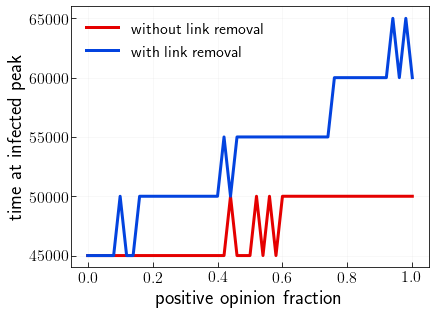

In [104]:
plot_vals(on, off, time_max_infected, 'time at infected peak')

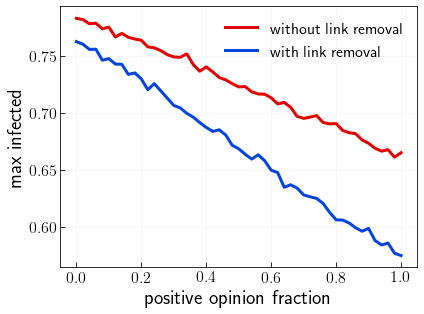

In [121]:
plot_vals(on, off, lambda x: max_by_columns(x, 'infectedRate'), 'max infected')

Text(0.5, 0, 'positive opinion fraction')

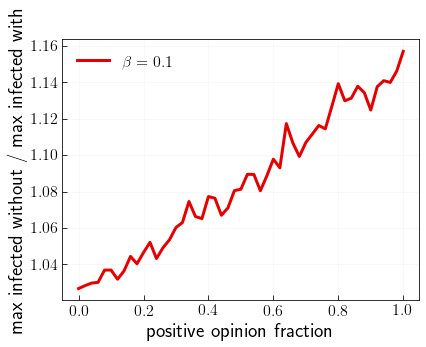

In [132]:
fun = lambda x: max_by_columns(x, 'infectedRate')
plt.plot(x, fun(off) / fun(on), color=colors[0], label=r'$\beta=0.1$')
plt.ylabel('max infected without / max infected with')
plt.legend()
plt.xlabel('positive opinion fraction')
# This means how much we gain by removing links

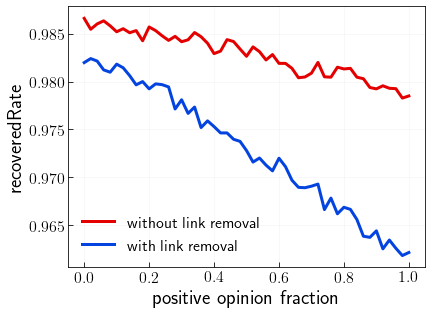

In [116]:
plot_vals(on, off, lambda x: last_by_columns(x, 'recoveredRate'), 'recoveredRate')

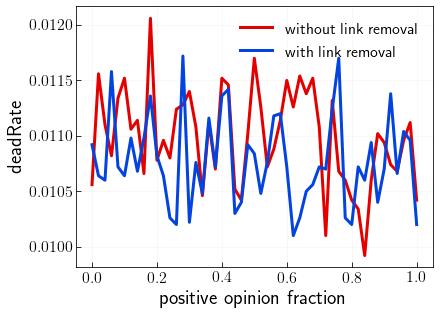

In [114]:
plot_vals(on, off, lambda x: last_by_columns(x, 'deadRate'), 'last dead rate')

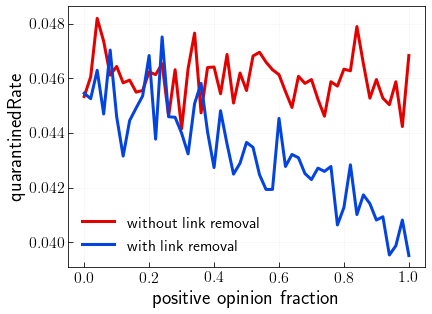

In [118]:
plot_vals(on, off, lambda x: max_by_columns(x, 'quarantinedRate'), 'max quarantined rate')

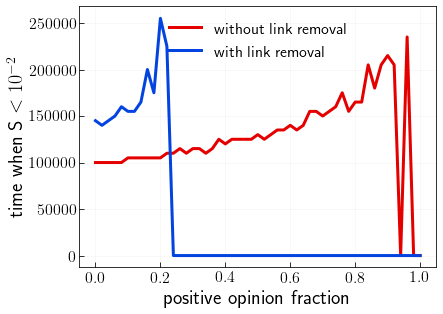

In [119]:
plot_vals(on, off, time_to_no_susceptible, r'time when S $< 10^{-2}$')